# Chapter 02


In [1]:
from __future__ import print_function, division
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns

np.random.seed(0)

## P28 一標本t検定

対照実験を想定した関連2群のデータを生成してみる  
A:統制群 B:実験群と仮定  
A,B間には真の効果量dが存在するとする．同一個体から2条件分のデータを得ることを想定すると，サンプリングは次の2ステップで行われる  
A．個体の母平均をmu_aと置くと，各個体の統制条件でのデータはmu_a + 個体差として表される．個体差が分散var_aの正規分布に従うとすると，AのデータはN(mu_a, var_a)に従う  
B．条件Bのデータを 各個体の統制データA + 効果量d + ノイズ　として計算する．この時ノイズは確率変数で，実験の効果のばらつきを表す

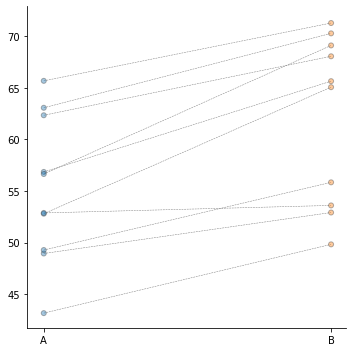

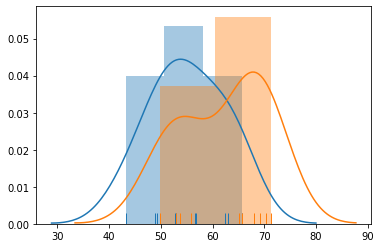

In [2]:
nsample = 10
d_true = 5

# Define params of cond A (= mean and variance of individuals)
mu_a, std_a = 50, 7
# Define params of cond B (= mean and variance of noise)
mu_b, std_b = 0, 5

# Step1
# Sample A from normal
xa = stats.norm.rvs(loc=mu_a, scale=std_a, size=(nsample,1))

# Step2
# Sample noise and calc B
noise = stats.norm.rvs(loc=mu_b, scale=std_b, size=(nsample,1))
xb = xa + d_true + noise

samples = pd.DataFrame(np.c_[xa, xb], columns=['A', 'B'])

# Plot paired strip
sns.catplot(data = samples, kind = 'strip', jitter=False, alpha=.40, linewidth = 1)
plt.plot([samples.iloc[:,0], samples.iloc[:,1]], color = 'grey', linewidth = 0.5, linestyle = '--')
plt.show()

# Plot histgram
sns.distplot(xa, norm_hist=True, kde=True, rug=True)
sns.distplot(xb, norm_hist=True, kde=True, rug=True)
plt.show()

上で作ったデータに対して，一標本t検定を行う

d_mean:-7.00, d_std:3.55
t-value:-6.24
p-value:0.00015145400930771657
Ttest_relResult(statistic=-6.239883170035028, pvalue=0.00015145400930775534)


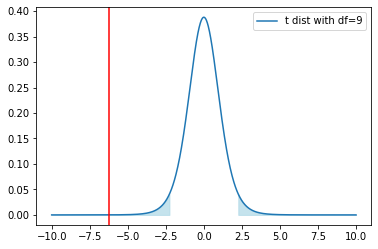

In [3]:
# Calc mean and unbiased std of d
d = samples['A'] - samples['B']
d_mean = d.mean()
d_std = d.std(ddof=1)

print('d_mean:' + format(d_mean,'.2f') + ', d_std:' + format(d_std,'.2f'))

# Calc t-value
n = len(d)
se = d_std / np.sqrt(n)
tval = d_mean / se

print('t-value:' + format(tval,'.2f'))

# Calc p-value
# p-val is cumulate area of t-distribution more right part than abs(tval)
pval_one = 1-stats.t.cdf(np.abs(tval), df=n-1)
# when calc two-side probability, left part is considered, so area is multiplied
pval_two = pval_one*2
# these are also calculated using sf (survival function)
# pval_one = stats.t.sf(np.abs(tval), df=n-1)

print('p-value:' + str(pval_two))

# Verify result using scipy
result = stats.ttest_rel(samples['A'], samples['B'])
print(result)

# Plot t-distribution with df=n-1 
x = np.linspace(-10, 10, 1000)
y = stats.t.pdf(x, df=n-1)
sns.lineplot(x,y, label='t dist with df='+str(n-1))

# Fill area with alpha=0.05 (two-side)
alpha = 0.05
lower_bound = stats.t.ppf(alpha/2, df=n-1)
Xlb = np.linspace(-10, lower_bound, 100)
Ylb = stats.t.pdf(Xlb, df=n-1)
plt.fill_between(Xlb, Ylb, color="lightblue", alpha=0.7)
upper_bound = stats.t.ppf(1-alpha/2, df=n-1)
Xub = np.linspace(upper_bound, 10, 100)
Yub = stats.t.pdf(Xub, df=n-1)
plt.fill_between(Xub, Yub, color="lightblue", alpha=0.7)

# Add vertical line of t-value
plt.axvline(x=tval, ymin=0, ymax=1, color='red') # add vertical line with x=z
plt.show()

## P38 イメージレッスン　有意差のめやす

サンプル数nを固定し，一標本t検定の結果が指定したp値を示すようなサンプル群A,Bを生成することを考えてみる  
片側確率の場合から考えてみると，t値とp値の関係は  
$$
\begin{align}
    \mathit{pval} &= \int_{t=|\mathit{tval}|}^{\infty}Pt(t|\mu=0,\mathit{var}=1,\mathit{df}=n-1) \quad \\
    &= 1 - \mathit{t.cdf}(|\mathit{tval}|, \mathit{df})
\end{align}
$$
Ptはt分布で，tvalはnサンプルから計算されたt値とする．片側確率なので，上側の面積を計算するとして，tvalは絶対値をとっている．  
上はt値からp値を求める計算で，上述のように1-cdfもしくはsf(survival function)を用いて計算できる．両側確率を求める場合は，上の式を2倍すれば良い．  
今回計算したいのは，p値がわかっている時のt値である．これはppf(Percent point function)によって求められる．したがって  
$$
    \mathit{tval} = \mathit{t.ppf}(1-\mathit{pval}, \mathit{df})
$$
これで任意のp値に対するt値が得られる．次はt値とサンプル数n，そして推定効果量の平均d_meanと不偏分散d_varの関係を考える  
$$
    \mathit{tval} = \frac{d_{\mathit mean}}{\sqrt{d_{\mathit var}/n}}
$$

ここで，サンプル平均には何らかの値を予め仮定するとすれば，不偏標準偏差は
$$
\begin{align}
    {\sqrt \frac{d_{\mathit var}}{n} } &= \frac{d_{\mathit mean}}{\mathit{tval}} \\
    d_{\mathit std} &= \frac{d_{\mathit mean} \sqrt{n}}{\mathit{tval}} \\
\end{align}
$$

統制群aと実験群bは次のような正規分布からサンプリングされる  
$$
    a \sim {\mathcal N}(\mu_a, {\mathit var}_a) \\
\begin{align}
    b|a &= a+d_{\mathit true} + \varepsilon \\
    &\sim {\mathcal N}(a+d_{\mathit true}, {\mathit var}_\varepsilon) \\
\end{align}
$$

この時，差dの分布は次の通り(上のようにd=a-bで定義すれば平均が-d_trueになる)  
$$
\begin{align}
    d &= b - a \\
    &= d_{\mathit true} + \varepsilon \\
    &\sim {\mathcal N}(d_{\mathit true}, {\mathit var}_\varepsilon)
\end{align}
$$

従って，平均と分散がdの分布に従うような乱数をサンプリングした後，適当なaを使ってbを計算すれば良い．  
サンプリングした乱数が任意の平均と分散を持つためには，まず任意の分布からサンプリングした乱数群に対して，その平均と不偏分散で標準化した後に，z * std + muと変換．  
この時mu=d_mean, std=sqrt(d_std^2*(n-1)/n)とすれば，任意のp値を示すサンプル群を得られる．

Designed p-value:0.05
Corresponding t-value:2.26


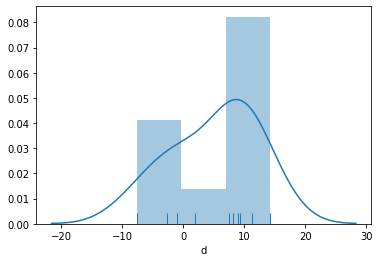

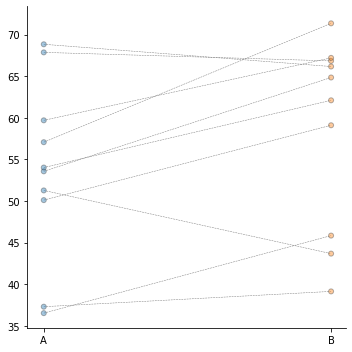

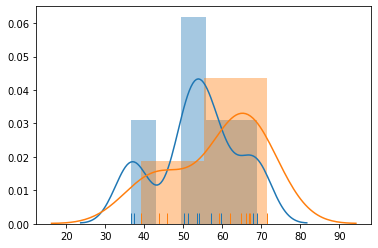

Ttest_relResult(statistic=2.26215716274099, pvalue=0.05000000000467578)


In [8]:
# ---Modulate these variables---
n = 10
pval = 0.05/2 # designed p-value (two-side)
d_true = 5
# ------------------------------

d_mean = d_true # set mean of sampled d as same as d_true

# Population of a
mu_a, std_a = 50, 10 # no effect on resulted statistics

# Calc t-value which corresponds to designed p-value with df=n-1
tval = stats.t.ppf(1-pval, df=n-1)

# Calc d_std which corresponds to designed p-value
d_std = (d_mean*np.sqrt(n)) / tval # designed unviased std

print('Designed p-value:' + str(pval*2))
print('Corresponding t-value:' + format(tval,'.2f'))

# Draw n samples from standard normal
xz = stats.norm.rvs(loc=0, scale=1, size=n)
# Standadize samples 
xz = (xz - xz.mean()) / xz.std()

# Convert z to d with designed unbiased std and mean
xd = xz* np.sqrt(pow(d_std,2)*(n-1)/n) # scaling
xd = xd + d_mean # shifting

# --Debug-- Check mean and unbiased std of samples
# print(xd.mean())
# print(xd.std(ddof=1))
# print(d_std) # designed d_std

# Randomly draw a for each sample
xa = stats.norm.rvs(loc=mu_a, scale=std_a, size=n)

# Calc b from a and d (d contain measurement noise)
xb = xa + xd

# Store a and b to samples
samples = pd.DataFrame(np.c_[xa, xb], columns=['A', 'B'])

# Plot histgram of d
xd = pd.Series(xd, name="d")
sns.distplot(xd, norm_hist=True, kde=True, rug=True)
plt.show()


# Plot paired strip
sns.catplot(data = samples, kind = 'strip', jitter=False, alpha=.40, linewidth = 1)
plt.plot([samples.iloc[:,0], samples.iloc[:,1]], color = 'grey', linewidth = 0.5, linestyle = '--')
plt.show()

# Plot histgram
sns.distplot(xa, norm_hist=True, kde=True, rug=True)
sns.distplot(xb, norm_hist=True, kde=True, rug=True)
plt.show()

# Verify result using scipy
result = stats.ttest_rel(samples['B'], samples['A'])
print(result)

面倒なので教科書のように色々なnに対応する時の図を作ることはしないが，上のコード中のn, pval, d_trueをいじると色々な条件に対応するサンプル群A,Bを生成できる．  
(dに含まれるノイズ量が調整される)